In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
import json
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd
import random

from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem

import sys
sys.path.insert(0, '../')
from scripts import build_vae, decode_smiles, generate_structures, my_colors, MoleculeVAE

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '../../gains/gains/')
import engine as genetic

In [3]:
target = "CCCC" #butane smiles
parent_candidates = np.array(["CCCOCCC"]) #propanol smiles, numpy array

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

def fnGetFitness(genes, target):
    return get_fitness(genes, target)

def display(candidate, mutation, asdf):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))
    
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates, mutate=genetic._mutate)

  starting structure         0.1905        CCCOCCC
         remove_atom         0.2000         CCCOCC
        replace_atom         0.2083         CCCOCF
         remove_atom         0.2353          CCCOC
         remove_atom         0.3333           CCCO
        replace_atom         1.0000           CCCC
    number of atoms:              4
  mutation attempts:             82


In [4]:
#M5 data
vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']
weights_file = "../data/{}".format(vae_models[-1])
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
chemvae = MoleculeVAE()
char_set = set(char_to_index.keys())
chemvae.load(char_set, weights_file)

In [17]:
def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))
        
def one_hot(smi, char_to_index):
    test_smi = smi
    smile_max_length=51
    char_set = set(char_to_index.keys())
    test_smi = pad_smiles(test_smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(list(char_set))), dtype=np.bool)
    for t, char in enumerate(test_smi):
        Z[0, t, char_to_index[char]] = 1
    return Z

def vae_mutate(parent, geneSet, get_fitness, target, limit=1e3):
#     while True:
#         candidate = chemvae.encoder.predict(one_hot(parent, char_to_index))
    limit_counter = 0
    while True:
#         iteration += 1
        limit_counter += 1
        t = random.random()*2
        candidate = decode_smiles(chemvae.autoencoder, parent.Genes, char_to_index, temp=t).split(" ")[0]
        
        try:
            sampled = Chem.MolFromSmiles(candidate)
            cation = Chem.AddHs(sampled)
            Chem.EmbedMolecule(cation, Chem.ETKDG())
            Chem.UFFOptimizeMolecule(cation)
            cation = Chem.RemoveHs(cation)
            candidate = Chem.MolToSmiles(cation)
            fitness, prediction = get_fitness(candidate, target)
#             print(candidate, fitness)
            mutation = 'vae mutation'
            return genetic.Chromosome(candidate, fitness), mutation
        except:
            pass
        if limit_counter > limit:
            mutation = 'vae mutation'
            return genetic.Chromosome(parent.Genes, 0), mutation

  starting structure         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC


../scripts/vae.py:175: RuntimeWarning: invalid value encountered in true_divide
  dist = np.exp(a)/np.sum(np.exp(a))
../scripts/vae.py:177: RuntimeWarning: invalid value encountered in less
  return np.random.choice(choices, p=dist)


        vae mutation         0.4661	CCNC1(OCO)CNCCC1NC
        vae mutation         0.4746	CCCCCCC1CCCCCC1CCC
        vae mutation         0.5085	CCCCCCC1CCCCC1CCC
starting from new parent
        vae mutation         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC
        vae mutation         0.4568	NNCC1(C2=CCC2O)CN1
        vae mutation         0.4737	CCCCC1C2=C(CC2)CNC1OCC
        vae mutation         0.4915	CCC1CCCCCC2CCCCCC2CC1
        vae mutation         0.5246	       COCCCCCN
starting from new parent
        vae mutation         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4576	CCC[C+]1CCC(C)CC1
        vae mutation         0.5085	CCCCCCCCCC1CCCCC1C
starting from new parent
        vae mutation         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC
        vae mutation         0.4490	CCNC1(CCO)C(=O)CNC1O
        vae mutation         0.4516	C=C(CCCCC)CCCCCCCCCC
        vae mutation         0.4576	CCCCC1

/home/wesleybeckner/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC
        vae mutation         0.4553	CCNC1(OCC)CCCNC1=O
        vae mutation         0.4576	CCCC1CCCCCCCCCC1C
        vae mutation         0.4746	CCCCCCC1CCCCCC1CC
        vae mutation         0.5085	CCCCCCCC1CCCCC1CC
        vae mutation         0.5167	 CCCCCCCSCCCCCC
starting from new parent
        vae mutation         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC
        vae mutation         0.4776	CCNN1CC=CCC1(CCO)OCC
        vae mutation         0.5085	CCCCCCCCCCC1CCCCC1CC
starting from new parent
        vae mutation         0.4293	CCCn1cc[n+](c1C)C
        vae mutation         0.4407	[C+]C(CCC)C(CC)CCC
        vae mutation         0.4636	C=C(CCC=CCCC)NC
        vae mutation         0.4694	CNC1=CCOCCC12CCCCOOO2
        vae mutation         0.4724	CCCCNC12CCC13CC3OOCO2
        vae mutation         0.4774	CCCCOC1CC12CC21NCCC1C
        vae mutation         0.4858	CCCCCC1OC2C1C21N=CC1C
        va

KeyboardInterrupt: 

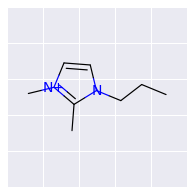

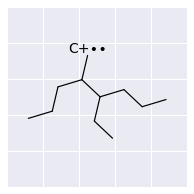

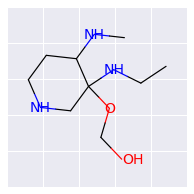

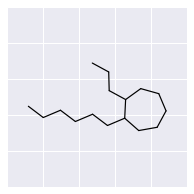

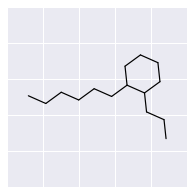

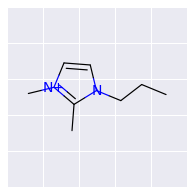

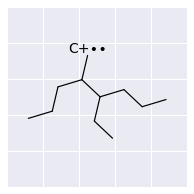

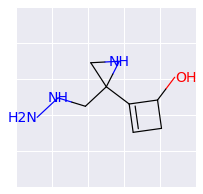

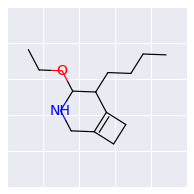

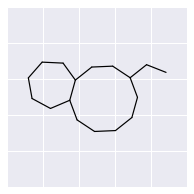

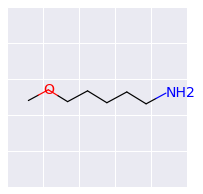

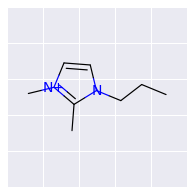

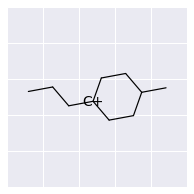

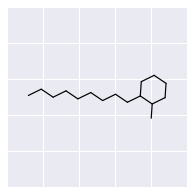

In [ ]:
target = cations[0] #butane smiles
parent_candidates = np.array([cations[1]]) #propanol smiles, numpy array

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

def fnGetFitness(genes, target):
    return get_fitness(genes, target)

def display(candidate, mutation, asdf):
    print("{:>20}{:>15}\t{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))
    Draw.MolToMPL(Chem.MolFromSmiles(candidate.Genes), size=(100,100))

def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))
    
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates, mutate=vae_mutate)

In [22]:
genetic._mutate?

Signature: genetic._mutate(parent, geneSet, get_fitness, target)
Docstring: <no docstring>
File:      /media/wesleybeckner/weshhd/wes/Dropbox/Python/py3/gains/gains/engine.py
Type:      function


In [23]:
decode_smiles?

Signature: decode_smiles(vae, smi, char_to_index, temp=0.5, smile_max_length=51)
Docstring:
vae: variational autoencoder to encode/decode input
smi: smiles string to encode
temp: temperature at which to perform sampling
File:      /media/wesleybeckner/weshhd/wes/Dropbox/Python/py3/generative_learners_salts/scripts/vae.py
Type:      function


In [ ]:
import numpy as np
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem

target = cations[0] 
parent_candidates = np.array([cations[1]])

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

def fnGetFitness(genes, target):
    return get_fitness(genes, target)

def display(candidate, mutation, asdf):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))
    
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates, mutate=genetic._mutate)

  starting structure         0.4293CCCn1cc[n+](c1C)C
 add_custom_fragment         0.4612CCCc1cn(CCC)c(C)[n+]1C
  add_rdkit_fragment         0.4699CCCc1cn(CCC)c(C)[n+]1CC(C)=O
            add_atom         0.4805CCCc1c(F)n(CCC)c(C)[n+]1CC(C)=O
        replace_atom         0.4843CCBn1c(F)c(CCC)[n+](CC(C)=O)c1C
         remove_atom         0.4862CCBn1c(F)c(CC)[n+](CC(C)=O)c1C
         remove_atom         0.4881CCBn1c(F)c(CC)[n+](CC=O)c1C
         remove_atom         0.4920CCBn1c(F)c(C)[n+](CC=O)c1C
starting from new parent
 add_custom_fragment         0.4293CCCn1cc[n+](c1C)C
  add_rdkit_fragment         0.4553CCCn1cc[n+](CNC(C)=O)c1C
            add_atom         0.4615CCCn1cc[n+](CN(N)C(C)=O)c1C
            add_atom         0.4637CCCn1cc[n+](CN(N)C(=O)CCl)c1C
            add_atom         0.4659CCCn1cc[n+](CN(NC)C(=O)CCl)c1C
            add_atom         0.4745CCCn1cc(S)[n+](CN(NC)C(=O)CCl)c1C
  add_rdkit_fragment         0.4824CCCn1cc(S)[n+](CN(NCS(=O)(=O)Cl)C(=O)CCl)c1C
         remove_ato